In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import re
from scipy.interpolate import griddata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

from cofactor.features import Features
from cofactor.model import LatticePredictor
from cofactor.calculator import CofactorCalculator

In [4]:
featgen = Features.from_excel('data/elemental.xlsx')
model = LatticePredictor.from_file('models/model.pkl')
data = pd.read_csv('data/lattices.csv', index_col=0)

In [5]:
CORRECTION_SHIFT = 109.45617492701103

def features_from_df(df, element1, element2, apply_correction=False):
    df['T0'] = df['T0 (K)'] - 273
    if apply_correction:
        df['T0'] += CORRECTION_SHIFT

    df['Ms'] = df['Ms (K)'] - 273
    df['x'] = to_mol_percent(df, element1)
    df['y'] = to_mol_percent(df, element2)
    
    inputs = {
        element1: df['x'].values.reshape(-1, 1),
        element2: df['y'].values.reshape(-1, 1),
        'Zr': 1 - df['x'].values.reshape(-1, 1) - df['y'].values.reshape(-1, 1),
        'T': df.T0.values.reshape(-1, 1),
        'Ms': df.Ms.values.reshape(-1, 1),
        'hyst': (df.T0 - df.Ms).values.reshape(-1, 1),
    }
    X = featgen.get_features(inputs, model.features)
    
    return X

def get_cofactors(X, model):
    cofactors = []
    dV = []
    for tetr, mono in model.predict_lattice(X[model.features]):
        calc = CofactorCalculator(tetr, mono)
        cofactors.append(calc.get_cofactors())
        dV.append(calc.get_volume_change())

    return pd.concat([
        X,
        pd.DataFrame(cofactors),
        (pd.DataFrame(dV) - 1) * 100
    ], axis=1)

def get_gradient(results, element, prop):
    grad_dilute = results[[element, 'T', prop]][:2].diff().iloc[-1]
    
    dT_dx = grad_dilute['T'] / grad_dilute[element]
    dL_dx = grad_dilute[prop] / grad_dilute[element]
    
    return dT_dx, dL_dx

def to_mol_percent(df, element):
    def get_column(df, element):
        for col in df.columns:
            if element in col:
                return col
    
    col = get_column(df, element)
    x = df[col] / 100
#     num = re.findall(element + '(\d)O', col)
#     if len(num) == 0:
#         return x

#     return x / (int(num[0]) - x)
    a = re.findall(element + '(\d)O', col)

    if len(a) == 0:
        return x
    
    a = int(a[0])
    
    return a * x / (1 + x)

### Design charts

In [6]:
UNCERTAINTY_LAMBDA = 0.001145

ELEMENT_STR = {
    'Al': r'Al$^{3+}$',
    'Ca': r'Ca$^{2+}$',
    'Ce': r'Ce$^{4+}$',
    'Cr': r'Cr$^{3+}$',
    'Gd': r'Gd$^{3+}$',
    'Hf': r'Hf$^{4+}$',
    'La': r'La$^{3+}$',
    'Ti': r'Ti$^{4+}$',
    'Y': r'Y$^{3+}$',
    'Zr': r'Zr$^{4+}$',
}

PROP_LABEL = {
    'B_lambda': r'\lambda_2',
    'Ms': r'M_s',
    'hyst': r'(T_0 - M_s)',
    'B_dV': r'\Delta V',
}
PROP_UNIT = {
    'B_lambda': '1',
    'Ms': r'$^\circ$C',
    'hyst': '$^\circ$C',
    'B_dV': r'%'
}

COLOR_LABEL = {
    'T': "#d62728",
    'Ms': "#ff7f0e",
    'hyst': "#1f77b4",
    'B_lambda': "#2ca02c",
    'B_dV': "#9467bd",
    'A_lambda': "#2ca02c",
    'A_dV': "#9467bd",
}

PATH = 'data/quaternary/'

In [7]:
def get_results_from_file(file, apply_correction=False):
    element1, element2 = file.strip('.csv').split('_')
    df = pd.read_csv(os.path.join(PATH, file)).dropna()
    X = features_from_df(df, element1, element2, apply_correction=apply_correction)
    results = get_cofactors(X, model)
    
    return results

In [8]:
def fit_plane(results, element1, element2, output):
    X = np.stack([results[element1], results[element2], np.ones_like(results[element2])], axis=1)
    coef, _, _, _ = lstsq(X, results[output])
    def plane(x, y):
        xy = np.stack([x, y, np.ones_like(y)], axis=1)
        return xy @ coef.reshape(-1, 1)
    
    return plane

def get_grid_and_interpolate(results, element1, element2, output):
    grid_x, grid_y = np.mgrid[0:results[element1].max():100j, 0:results[element2].max():100j]
    z = griddata(
        (results[element1].values, results[element2].values),
        results[output].values,
        (grid_x, grid_y),
        method='cubic'
    )
    return grid_x, grid_y, z

In [9]:
def get_grid_planar_fit(results, element1, element2):
    grid_x, grid_y = np.mgrid[0:results[element1].max():100j, 0:results[element2].max():100j]
    
    lambda_plane = fit_plane(results, element1, element2, 'B_lambda')
    T_plane = fit_plane(results, element1, element2, 'T')
    Ms_plane = fit_plane(results, element1, element2, 'Ms')
    
    L = lambda_plane(grid_x.reshape(-1), grid_y.reshape(-1)).reshape(grid_x.shape)
    T = T_plane(grid_x.reshape(-1), grid_y.reshape(-1)).reshape(grid_x.shape)
    Ms = Ms_plane(grid_x.reshape(-1), grid_y.reshape(-1)).reshape(grid_x.shape)
    
    return grid_x, grid_y, (L, T, Ms)

### Plotting with the plane

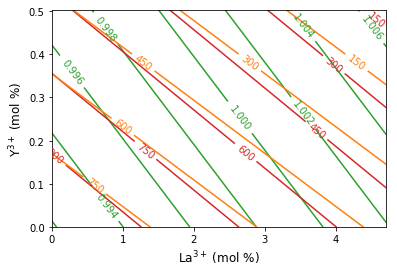

In [12]:
fig, ax = plt.subplots()

element1, element2 = 'La', 'Y'
results = get_results_from_file('La_Y.csv')
grid_x, grid_y, (L, T, Ms) = get_grid_planar_fit(results, element1, element2)

grid_x *= 100
grid_y *= 100

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, T,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['T'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.0f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)
    
# set the limits of the plot to the limits of the data
ax.axis([grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

# ax.legend()
plt.show()

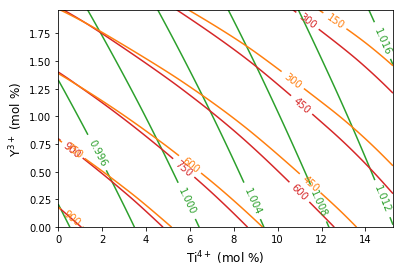

In [23]:
fig, ax = plt.subplots()

results = get_results_from_file('La_Y.csv')
grid_x, grid_y, L = get_grid_and_interpolate(results, 'La', 'Y', 'B_lambda')
_, _, T = get_grid_and_interpolate(results, 'La', 'Y', 'T')
_, _, Ms = get_grid_and_interpolate(results, 'La', 'Y', 'Ms')

grid_x *= 100
grid_y *= 100

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, T,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['T'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.0f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)
    
# set the limits of the plot to the limits of the data
ax.axis([grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

# ax.legend()
plt.show()

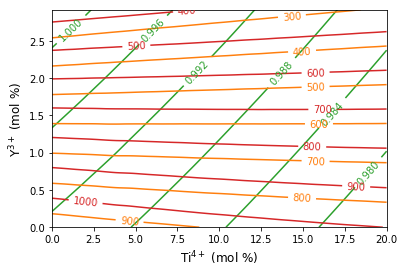

In [24]:
fig, ax = plt.subplots()

element1, element2 = 'Ti', 'Y'
results = get_results_from_file(f'{element1}_{element2}.csv')
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'B_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')

grid_x *= 100
grid_y *= 100

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, T,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['T'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.0f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)
    
# set the limits of the plot to the limits of the data
ax.axis([grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

# ax.legend()
plt.show()

### Applying the correction to T0:

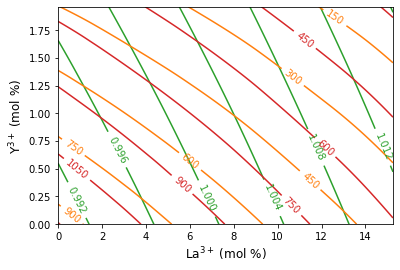

In [10]:
fig, ax = plt.subplots()

element1, element2 = 'La', 'Y'
results = get_results_from_file(f'{element1}_{element2}.csv', apply_correction=True)
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'B_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')

grid_x *= 100
grid_y *= 100

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, T,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['T'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.0f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)
    
# set the limits of the plot to the limits of the data
ax.axis([grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

fig.savefig(f'figs/ternary_{element1}_{element2}.pdf')
# ax.legend()
plt.show()

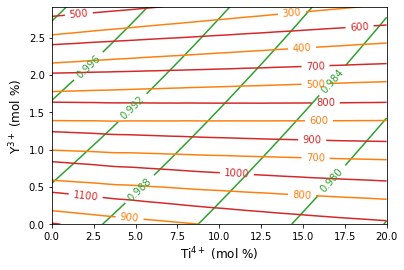

In [11]:
fig, ax = plt.subplots()

element1, element2 = 'Ti', 'Y'
results = get_results_from_file(f'{element1}_{element2}.csv', apply_correction=True)
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'B_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')

grid_x *= 100
grid_y *= 100

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, T,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['T'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.0f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)
    
# set the limits of the plot to the limits of the data
ax.axis([grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

# ax.legend()
fig.savefig(f'figs/ternary_{element1}_{element2}.pdf')
plt.show()

### Adding the hysteresis as well

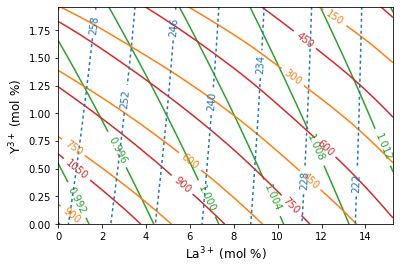

In [12]:
fig, ax = plt.subplots()

element1, element2 = 'La', 'Y'
results = get_results_from_file(f'{element1}_{element2}.csv', apply_correction=True)
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'B_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')
_, _, hyst = get_grid_and_interpolate(results, element1, element2, 'hyst')

grid_x *= 100
grid_y *= 100

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, T,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['T'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.0f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)

CS4 = ax.contour(
    grid_x, grid_y, hyst,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['hyst'],
)
ax.clabel(CS4, CS4.levels, fmt='%1.0f', inline=True, fontsize=10)
for c in CS4.collections:
    c.set_dashes([(0, (2.0, 2.0))])
    
# set the limits of the plot to the limits of the data
ax.axis([grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

fig.savefig(f'figs/ternary_{element1}_{element2}.pdf')
# ax.legend()
plt.show()

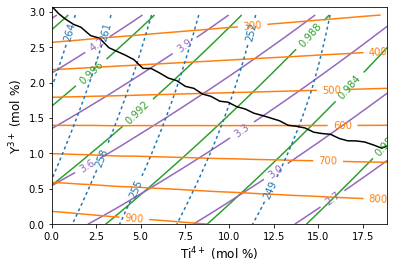

In [10]:
fig, ax = plt.subplots()

element1, element2 = 'Ti', 'Y'
results = get_results_from_file(f'{element1}_{element2}.csv', apply_correction=True)
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'B_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')
_, _, hyst = get_grid_and_interpolate(results, element1, element2, 'hyst')
_, _, dV = get_grid_and_interpolate(results, element1, element2, 'B_dV')
solubility = pd.read_csv(os.path.join(PATH, f'solubility_{element1}_{element2}.csv')).dropna()

grid_x *= 100
grid_y *= 100

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, dV,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_dV'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.1f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)

CS4 = ax.contour(
    grid_x, grid_y, hyst,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['hyst'],
)
ax.clabel(CS4, CS4.levels, fmt='%1.0f', inline=True, fontsize=10)
for c in CS4.collections:
    c.set_dashes([(0, (2.0, 2.0))])
    
ax.plot(solubility.iloc[:, 0], solubility.iloc[:, 1], 'k')

# set the limits of the plot to the limits of the data
ax.axis([0, solubility.iloc[:, 0].max(), 0, solubility.iloc[:, 1].max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

fig.savefig(f'figs/ternary_{element1}_{element2}.pdf')
# ax.legend()
plt.show()

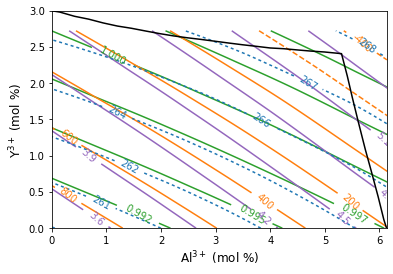

In [35]:
fig, ax = plt.subplots()

element1, element2 = 'Al', 'Y'
results = get_results_from_file(f'{element1}_{element2}.csv', apply_correction=True)
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'B_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')
_, _, hyst = get_grid_and_interpolate(results, element1, element2, 'hyst')
_, _, dV = get_grid_and_interpolate(results, element1, element2, 'B_dV')
solubility = pd.read_csv(os.path.join(PATH, f'solubility_{element1}_{element2}.csv')).dropna()

grid_x *= 100
grid_y *= 100

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, dV,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_dV'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.1f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)

CS4 = ax.contour(
    grid_x, grid_y, hyst,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['hyst'],
)
ax.clabel(CS4, CS4.levels, fmt='%1.0f', inline=True, fontsize=10)
for c in CS4.collections:
    c.set_dashes([(0, (2.0, 2.0))])
    
ax.plot(solubility.iloc[:, 0], solubility.iloc[:, 1], 'k')

# set the limits of the plot to the limits of the data
ax.axis([solubility.iloc[:, 0].min(),solubility.iloc[:, 0].max(), solubility.iloc[:, 1].min(), solubility.iloc[:, 1].max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

fig.savefig(f'figs/ternary_{element1}_{element2}.pdf')
# ax.legend()
plt.show()

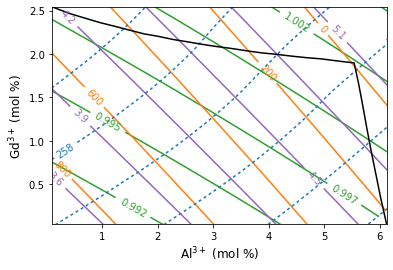

In [11]:
fig, ax = plt.subplots()

element1, element2 = 'Al', 'Gd'
results = get_results_from_file(f'{element1}_{element2}.csv', apply_correction=True)
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'B_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')
_, _, hyst = get_grid_and_interpolate(results, element1, element2, 'hyst')
_, _, dV = get_grid_and_interpolate(results, element1, element2, 'B_dV')
solubility = pd.read_csv(os.path.join(PATH, f'solubility_{element1}_{element2}.csv')).dropna()

grid_x *= 100
grid_y *= 100

ax.plot(solubility.iloc[:, 0], solubility.iloc[:, 1], 'k')

# set the limits of the plot to the limits of the data
ax.set_xlim(solubility.iloc[:, 0].min(),solubility.iloc[:, 0].max())
ax.set_ylim(solubility.iloc[:, 1].min(), solubility.iloc[:, 1].max())

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, dV,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_dV'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.1f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)

CS4 = ax.contour(
    grid_x, grid_y, hyst,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['hyst'],
)
ax.clabel(CS4, CS4.levels, fmt='%1.0f', inline=True, fontsize=10)
for c in CS4.collections:
    c.set_dashes([(0, (2.0, 2.0))])
    
# ax.plot(solubility.iloc[:, 0], solubility.iloc[:, 1], 'k')
# ax.axis([solubility.iloc[:, 0].min(),solubility.iloc[:, 0].max(), solubility.iloc[:, 1].min(), solubility.iloc[:, 1].max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

fig.savefig(f'figs/ternary_{element1}_{element2}.pdf')
# ax.legend()
plt.show()

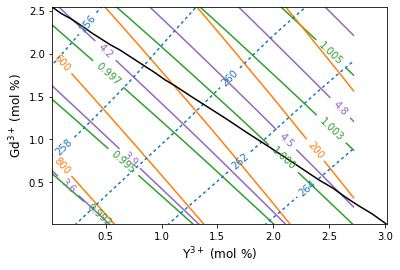

In [24]:
fig, ax = plt.subplots()

element1, element2 = 'Y', 'Gd'
results = get_results_from_file(f'{element1}_{element2}.csv', apply_correction=True)
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'B_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')
_, _, hyst = get_grid_and_interpolate(results, element1, element2, 'hyst')
_, _, dV = get_grid_and_interpolate(results, element1, element2, 'B_dV')
solubility = pd.read_csv(os.path.join(PATH, f'solubility_{element1}_{element2}.csv')).dropna()

grid_x *= 100
grid_y *= 100

ax.plot(solubility.iloc[:, 0], solubility.iloc[:, 1], 'k')

ax.set_xlim(solubility.iloc[:, 0].min(),solubility.iloc[:, 0].max())
ax.set_ylim(solubility.iloc[:, 1].min(), solubility.iloc[:, 1].max())

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_lambda'],
    levels=np.linspace(0.992, 1.008, 7)
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, dV,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['B_dV'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.1f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)

CS4 = ax.contour(
    grid_x, grid_y, hyst,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['hyst'],
)
ax.clabel(CS4, CS4.levels, fmt='%1.0f', inline=True, fontsize=10)
for c in CS4.collections:
    c.set_dashes([(0, (2.0, 2.0))])
    
# ax.plot(solubility.iloc[:, 0], solubility.iloc[:, 1], 'k')
# ax.axis([solubility.iloc[:, 0].min(),solubility.iloc[:, 0].max(), solubility.iloc[:, 1].min(), solubility.iloc[:, 1].max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

fig.savefig(f'figs/ternary_{element1}_{element2}.pdf')
# ax.legend()
plt.show()

### Plot experimental Ti-Hf data

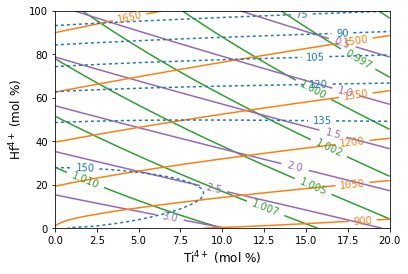

In [23]:
fig, ax = plt.subplots()

element1, element2 = 'Ti', 'Hf'
results = get_results_from_file(f'{element1}_{element2}.csv', apply_correction=False)
grid_x, grid_y, L = get_grid_and_interpolate(results, element1, element2, 'A_lambda')
_, _, T = get_grid_and_interpolate(results, element1, element2, 'T')
_, _, Ms = get_grid_and_interpolate(results, element1, element2, 'Ms')
_, _, hyst = get_grid_and_interpolate(results, element1, element2, 'hyst')
_, _, dV = get_grid_and_interpolate(results, element1, element2, 'A_dV')
# solubility = pd.read_csv(os.path.join(PATH, f'solubility_{element1}_{element2}.csv')).dropna()

grid_x *= 100
grid_y *= 100

# ax.plot(solubility.iloc[:, 0], solubility.iloc[:, 1], 'k')

# set the limits of the plot to the limits of the data
# ax.set_xlim(solubility.iloc[:, 0].min(),solubility.iloc[:, 0].max())
# ax.set_ylim(solubility.iloc[:, 1].min(), solubility.iloc[:, 1].max())

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['A_lambda'],
    levels=np.linspace(0.992, 1.010, 8)
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, dV,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['A_dV'],
)
ax.clabel(CS2, CS2.levels, fmt='%1.1f', inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['Ms'],
)
ax.clabel(CS3, CS3.levels, fmt='%1.0f', inline=True, fontsize=10)

CS4 = ax.contour(
    grid_x, grid_y, hyst,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors=COLOR_LABEL['hyst'],
)
ax.clabel(CS4, CS4.levels, fmt='%1.0f', inline=True, fontsize=10)
for c in CS4.collections:
    c.set_dashes([(0, (2.0, 2.0))])
    
# ax.plot(solubility.iloc[:, 0], solubility.iloc[:, 1], 'k')
# ax.axis([solubility.iloc[:, 0].min(),solubility.iloc[:, 0].max(), solubility.iloc[:, 1].min(), solubility.iloc[:, 1].max()])

ax.set_xlabel('%s (mol %%)' % ELEMENT_STR[element1], fontsize=12)
ax.set_ylabel('%s (mol %%)' % ELEMENT_STR[element2], fontsize=12)

fig.savefig(f'figs/ternary_{element1}_{element2}.pdf')
# ax.legend()
plt.show()